In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
nltk.download('stopwords', quiet=True)

True

# 1. Exploración de datos 

In [239]:
df_data = pd.read_excel(r"Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


## 1.1 Calidad de datos

### 1.1.1 Completitud

Se observa que no hay valores nulos en el dataset, hay 2424 filas y 2 columnas, y para cada columna ha 2424 valores no nulos. La columna `textos` es de tipo objeto (string) y la columna `labels` es de tipo entero (int64).

In [240]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [241]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [242]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [243]:
#Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [244]:
#Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.2 Unicidad

Se obsera que no hay duplicados en el dataset.

In [245]:
duplicados = df.duplicated(subset = ["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [246]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.3 Validez

Revisar que todas las opiniones estén en el mismo idioma (español).

In [247]:
# se demora alrededor de 20 segundos

from langdetect import detect

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["textos"].apply(detect_language)

print(len(df[df['language'] != 'es']))

0


Todos los textos están en español, no se encontraron textos en otros idiomas.

In [248]:
df = df.drop(columns=['language'])

### 1.1.4 Consistencia

In [249]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

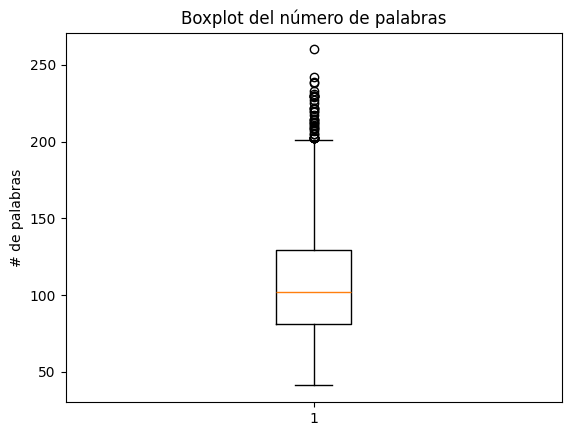

In [250]:
plt.boxplot(df['word_count'])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

Se observan outliers en textos que tienen una alta cantidad de palabras.

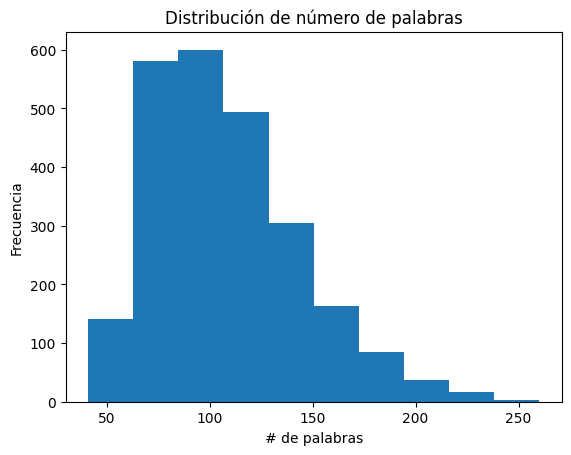

In [251]:
plt.hist(df['word_count'])
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()


## 1.2 Análisis de balance de clases

In [252]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame({"cantidad": df["labels"].value_counts(), "porcentaje": round(df["labels"].value_counts() / len(df), 2)})
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


Las clases 4 y 3 tienen una mayor representación en el dataset, mientras que las clases 1 tiene una representación menor.

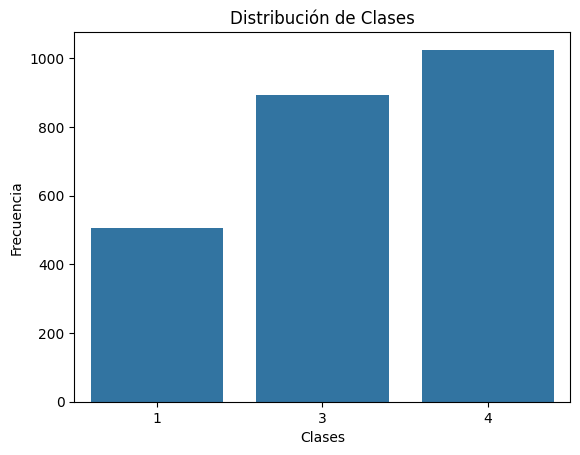

In [253]:
sns.barplot(x=df["labels"].value_counts().index, y=df["labels"].value_counts().values)
plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

# 2. Preparación de datos

In [254]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('spanish')

def normalize_text(text):
    #Elimina caracteres especiales y espacios en blanco
    doc = re.sub(r'[^a-zA-Z\s]', "", text, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    #Tokenizar documento
    tokens = wpt.tokenize(doc)
    #Filtrar palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Recrear documento de texto
    doc = ' '.join(filtered_tokens)
    return doc

df_normalizado = df.copy()
normalized_corpus = df_normalizado["textos"].apply(normalize_text)
df_normalizado["textos"] = normalized_corpus
df_normalizado.head()

,textos,labels,word_count
0,aprendizaje educacin consideran sinnimos escol...,4,48
1,nios ms pequeos bebs nios pequeos capacitacin ...,4,72
2,adems formacin especialistas medicina general ...,3,93
3,pases ocde tiende pasar cursos obligatorios op...,4,109
4,grupo centr personas padecen trastornos mental...,3,94


In [255]:
# recalcular word_count
df_normalizado["word_count"] = df_normalizado["textos"].apply(lambda x: len(str(x).split()))

In [256]:
df_normalizado.head()

,textos,labels,word_count
0,aprendizaje educacin consideran sinnimos escol...,4,27
1,nios ms pequeos bebs nios pequeos capacitacin ...,4,44
2,adems formacin especialistas medicina general ...,3,57
3,pases ocde tiende pasar cursos obligatorios op...,4,59
4,grupo centr personas padecen trastornos mental...,3,52


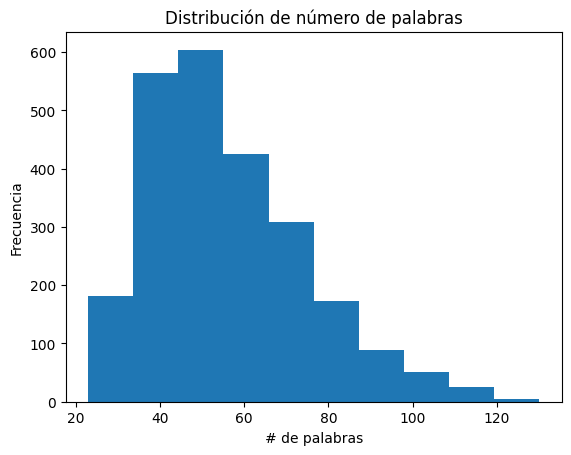

In [257]:
plt.hist(df_normalizado['word_count'])
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()

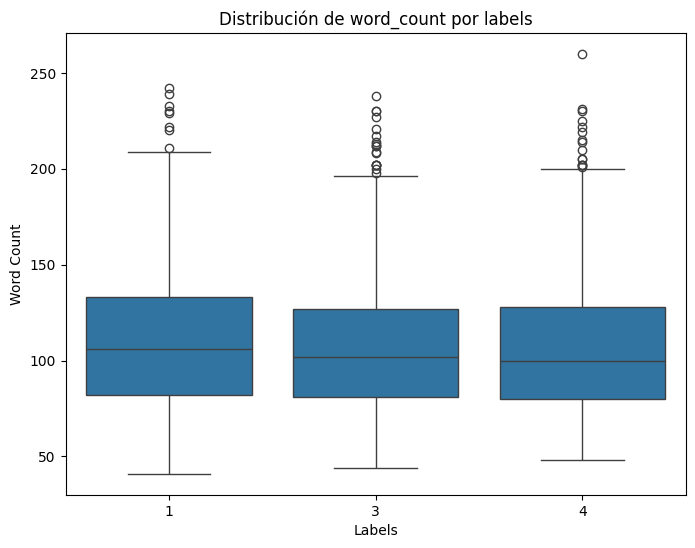

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='labels', y='word_count', data=df)

plt.title("Distribución de word_count por labels")
plt.xlabel("Labels")
plt.ylabel("word_count")
plt.show()

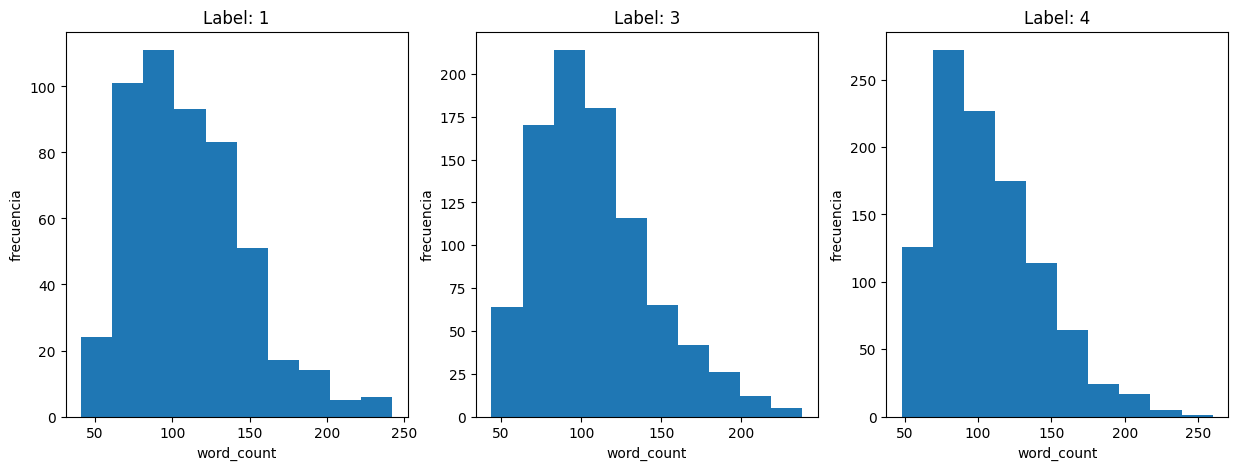

In [275]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for i, label in enumerate(sorted(df['labels'].unique())):
    ax[i].hist(df[df['labels'] == label]['word_count'])
    ax[i].set_xlabel("word_count")
    ax[i].set_ylabel("frecuencia")
    ax[i].set_title(f"Label: {label}")
    
    
plt.show()

La distribución de la cantidad de palabras por clase es muy similar, por lo que se condiera que esta característica no aporta valor para la clasificación.